# Demo of `columnsfmri` 
## Toolbox for simulation and optimization of fMRI of cortical column patterns
## `https://github.com/AS-Lab/Chaimow-Ugurbil-Shmuel-2017-Optimization-of-High-Res-fMRI` ##
## follow now interactively: `bit.ly/ohbm2019` ##

Import model implementation from columnsfmri.py as well as other useful modules:

In [1]:
import columnsfmri

%matplotlib inline
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### A tour of the inner workings of the model

Inititialize simulation using a 512 x 512 grid on an area of 24 x 24 mm.  

In [2]:
N = 512; L = 24
sim = columnsfmri.simulation(N,L)

Simulate a column pattern by filtering Gaussian white noise. Rho is the main pattern frequency, delta specifies the amount of irregularity (based on Rojer and Schwartz, 1990, and Niebur and Wörgötter, 1993).

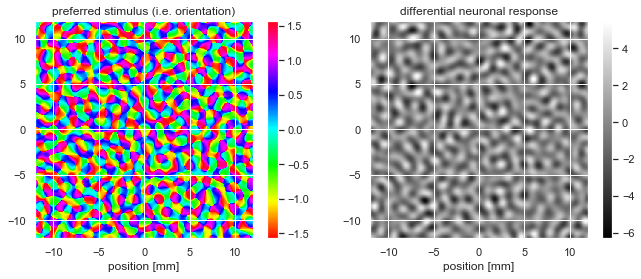

In [3]:
gwn = sim.gwnoise(); rho,deltaRelative = 0.625, 0.5
columnPattern,preferrenceMap = sim.columnPattern(rho,deltaRelative,gwn)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(preferrenceMap,'hsv',title='preferred stimulus (i.e. orientation)',ax=axes[0])
sim.plotPattern(columnPattern,title='differential neuronal response',ax=axes[1])

Simulate a differential spatial BOLD response with a FWHM of 1.02 mm (7T GE), and a corresponding single condition average response amplitude of 3.5%.

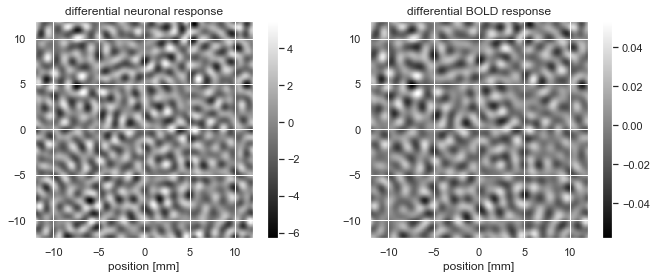

In [4]:
fwhm = 1.02
beta = 0.035
boldPattern,_,_ = sim.bold(fwhm,beta,columnPattern)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(columnPattern,title='differential neuronal response',ax=axes[0])
sim.plotPattern(boldPattern,title='differential BOLD response',ax=axes[1])

Simulate MRI sampling using a voxel width of 1 mm.

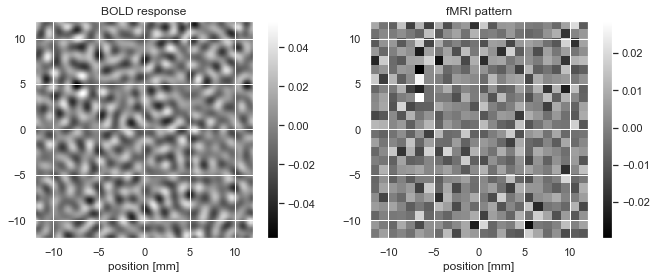

In [5]:
w = 1
mriPattern = sim.mri(w,boldPattern)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(boldPattern,title='BOLD response',ax=axes[0])
sim.plotPattern(mriPattern,title='fMRI pattern',ax=axes[1])

Quantify functional contrast _c_, as the standard deviation of all imaged differential responses (contrast range).

In [6]:
c = np.std(mriPattern)
print('c = %.2f%%' % (100*c))

c = 0.89%


Calculate the noise level (based on Triantafyllou et al. 1990) of a differential map as a function of voxel width (assume _nT_ = 1000 measurements at 7T using _TR_ = 2 s and a slice thickness of 2.5 mm).

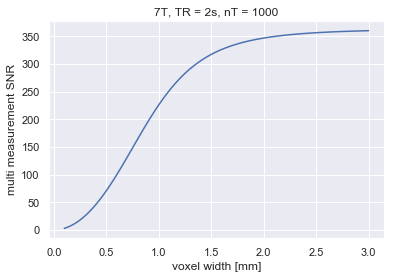

In [7]:
w = np.linspace(0.1,3,100)
sliceThickness = 2.5; V = w**2*sliceThickness
TR = 2; nT = 1000; differentialFlag = True; 
noiseType = '7T'
SNR = 1/columnsfmri.noiseModel(V,TR,nT,differentialFlag,noiseType=noiseType)

plt.plot(w,SNR); plt.xlabel('voxel width [mm]'); plt.ylabel('multi measurement SNR')
plt.title('7T, TR = 2s, nT = 1000'); plt.show()

SNR for a voxel width of 1 mm.

In [8]:
w = 1
V = w**2*sliceThickness
SNR = 1/columnsfmri.noiseModel(V,TR,nT,differentialFlag,noiseType=noiseType)
print('SNR = %.2f' % SNR)

SNR = 226.06


Compute contrast-to-noise ratio.

In [9]:
CNR = c * SNR
print('CNR = %.2f' % CNR)

CNR = 2.01


__Quantify univariate detection.__ Calculate the probability to detect a statistically significant differential response in a random single voxel.

In [10]:
p = columnsfmri.detectionProbability(CNR,1)
print('p = %.2f%%' % (100*p))

p = 38.31%


__Quantify multivariate detection/decoding.__ Calculate the probability *p* to detect a statistically significant differential response in a multivariate pattern of voxels and the expected accuracy _a_ with which we can decode the stimulus out of two possible classes.

In [11]:
roiArea = 87
nVoxels = roiArea/w**2
nClasses = 2
p = columnsfmri.detectionProbability(CNR,nVoxels)
print('p = %.2f%%' % (100*p))
a = columnsfmri.decodingAccuracy(CNR,nVoxels,nClasses)
print('a = %.2f%%' % (100*a))

p = 100.00%
a = 92.26%


__Quantify reconstruction.__ 1. Add noise to MRI pattern.

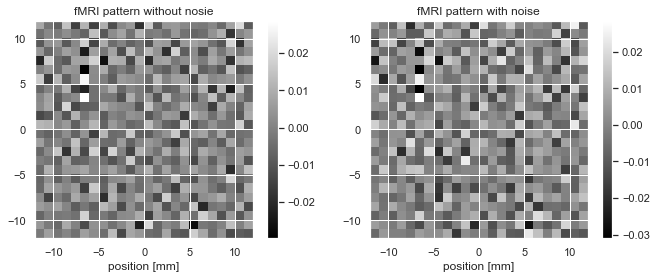

In [12]:
mriPlusNoisePattern = mriPattern + \
    (1/SNR) * np.random.randn(*mriPattern.shape)
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(mriPattern,title='fMRI pattern without nosie',ax=axes[0])
sim.plotPattern(mriPlusNoisePattern,title='fMRI pattern with noise',ax=axes[1])

__Quantify reconstruction.__ 2. Calculate the correlation between the original and the (zero-padding interpolated) imaged pattern.

R = 0.38


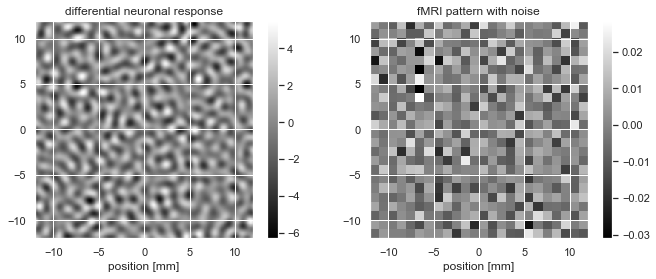

In [13]:
fig,axes = plt.subplots(1,2,figsize=(11,4))
sim.plotPattern(columnPattern,title='differential neuronal response',ax=axes[0])
sim.plotPattern(mriPlusNoisePattern,title='fMRI pattern with noise',ax=axes[1])
R = sim.patternCorrelation(columnPattern,mriPlusNoisePattern)
print('R = %.2f' % R)

### Run optimization simulation

Setting parameters:

In [14]:
help(columnsfmri.setParameters)

Help on function setParameters in module columnsfmri:

setParameters(*args)
    Sets parameters for simulatefMRIOfColumnPatterns.
    
    parameters = setParameters() returns default parameters.
    
    parameters = setParameters(s1,...) sets parameters according to
    predefined scenarios.
    s1,... are strings that select one of multiple scanner/pulse
    sequence and/or pattern irregularity scenarios:
    '3TGE','7TGE','7TSE','regular','irregular 
    
    parameters is a dictionary consisting of the following entries:
    
    randomNumberSeed    random number seed
    
    nTrials             number of simulation trials
    N                   simulation grid points along one dimension
    L                   simulation size along one dimension [mm]
    wRange              list of MRI voxel widths
                        (need to be divisors of L)                          
    rho                 main pattern frequency 
                        (~1/(2*column spacing) [1/mm]
   

Set standard parameters for optimization simulation.

In [15]:
parameters = columnsfmri.setParameters()
#parameters["fwhm"]=3
for parameter,value in parameters.items():
    print(parameter + ": " + str(value))

randomNumberSeed: 23
nTrials: 32
N: 512
L: 24
wRange: [4.         3.         2.4        2.         1.71428571 1.5
 1.33333333 1.2        1.09090909 1.         0.92307692 0.85714286
 0.8        0.75       0.70588235 0.66666667 0.63157895 0.6
 0.57142857 0.54545455 0.52173913 0.5        0.48       0.46153846
 0.44444444 0.42857143 0.4        0.375      0.35294118 0.32432432
 0.3        0.27272727 0.25       0.22641509 0.2        0.17391304
 0.15       0.125      0.1        0.075      0.05      ]
rho: 0.625
deltaRelative: 0.5
fwhm: 1.02
beta: 0.035
sliceThickness: 2.5
roiArea: 87
TR: 2
nT: 1000
noiseType: 7T


Run optimization simulation:

In [16]:
results = columnsfmri.simulatefMRIOfColumnPatterns(parameters)

Summarize results:

In [17]:
columnsfmri.printResults(results)

,optimized quantity,optimal value,optimal voxel width
0,univariate detection probability,0.424254,0.857143
1,multivariate detection probability,1.000000,0.857143
2,decoding probability - 2 classes,1.000000,0.800000
3,decoding accuracy - 2 classes,0.967097,0.800000
4,decoding probability - 4 classes,1.000000,0.800000
5,decoding accuracy - 4 classes,0.699691,0.800000
6,decoding probability - 8 classes,0.999968,0.800000
7,decoding accuracy - 8 classes,0.313242,0.800000
8,pattern correlation,0.784010,0.666667


Plot results:

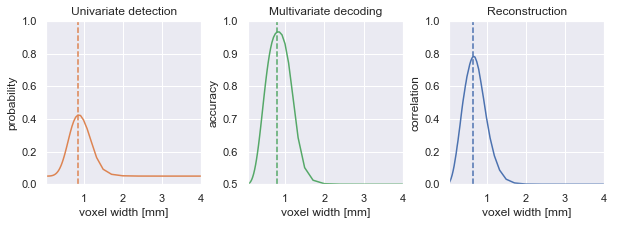

In [18]:
columnsfmri.displayFigureA(results)